In [1]:
import tensorflow as tf
import os
import pathlib
import glob
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [1]:
# Path to your dataset
dataset_path = "D:/Projects/OpenCV/war/dataset"


# Classes (sub-folder names in your 'images' folder)
classes = ['coco_cola','maaza','none','paper_bag','rice']

In [18]:
# Image size for MobileNetV2
img_size = (224, 224)
batch_size = 32

In [19]:
def load_and_preprocess_dataset(dataset_path, img_size, batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        dataset_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )
    # After creating the train_generator
    print(train_generator.class_indices)

    val_generator = train_datagen.flow_from_directory(
        dataset_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, val_generator
# Function to load and preprocess the dataset


In [5]:
'''# Example usage
dataset_path = "D:\Projects\OpenCV\war\dataset"
img_size = (224, 224)
batch_size = 32

train_generator, val_generator = load_and_preprocess_dataset(dataset_path, img_size, batch_size)

# Get a batch of images and labels from the training generator
images, labels = next(train_generator)

# Display the labels for the first 5 images
for i in range(5):
    print(f"Image {i + 1} - Label: {labels[i]}")'''


'# Example usage\ndataset_path = "D:\\Projects\\OpenCV\\war\\dataset"\nimg_size = (224, 224)\nbatch_size = 32\n\ntrain_generator, val_generator = load_and_preprocess_dataset(dataset_path, img_size, batch_size)\n\n# Get a batch of images and labels from the training generator\nimages, labels = next(train_generator)\n\n# Display the labels for the first 5 images\nfor i in range(5):\n    print(f"Image {i + 1} - Label: {labels[i]}")'

In [6]:
'''import matplotlib.pyplot as plt

def visualize_images(generator, num_images=5):
    # Get a batch of images and labels
    images, labels = next(generator)

    # Get class names from the generator
    class_names = list(generator.class_indices.keys())

    # Display the images and their corresponding class names
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        class_index = labels[i].argmax()  # Find the index of the class with the highest probability
        class_name = class_names[class_index]  # Get the class name
        plt.title(f"Class: {class_name}")
        plt.axis('off')

    plt.show()

# Example usage
dataset_path = "D:\Projects\OpenCV\war\dataset"
img_size = (224, 224)
batch_size = 32

train_generator, val_generator = load_and_preprocess_dataset(dataset_path, img_size, batch_size)

# Visualize training images
visualize_images(train_generator, num_images=5)

# Visualize validation images
visualize_images(val_generator, num_images=5)
'''

'import matplotlib.pyplot as plt\n\ndef visualize_images(generator, num_images=5):\n    # Get a batch of images and labels\n    images, labels = next(generator)\n\n    # Get class names from the generator\n    class_names = list(generator.class_indices.keys())\n\n    # Display the images and their corresponding class names\n    for i in range(num_images):\n        plt.subplot(1, num_images, i + 1)\n        plt.imshow(images[i])\n        class_index = labels[i].argmax()  # Find the index of the class with the highest probability\n        class_name = class_names[class_index]  # Get the class name\n        plt.title(f"Class: {class_name}")\n        plt.axis(\'off\')\n\n    plt.show()\n\n# Example usage\ndataset_path = "D:\\Projects\\OpenCV\\war\\dataset"\nimg_size = (224, 224)\nbatch_size = 32\n\ntrain_generator, val_generator = load_and_preprocess_dataset(dataset_path, img_size, batch_size)\n\n# Visualize training images\nvisualize_images(train_generator, num_images=5)\n\n# Visualize va

In [20]:
# Load and preprocess the dataset
train_generator, val_generator = load_and_preprocess_dataset(dataset_path, img_size, batch_size)

# Load MobileNetV2 pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

Found 180 images belonging to 5 classes.
{'coco_cola': 0, 'maaza': 1, 'none': 2, 'paper_bag': 3, 'rice': 4}
Found 43 images belonging to 5 classes.


In [21]:
# Add custom head for object detection
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
epochs = 10  # You can adjust the number of epochs
checkpoint_path = "model_checkpoint.h5"

# Save the best model during training
model_checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min', verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[model_checkpoint]
)

# Save the entire model
model.save("object_detection_model.h5")



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 31s 5s/step - loss: 1.4318 - accuracy: 0.6014 - val_loss: 0.4536 - val_accuracy: 0.8125
Epoch 2/10
5/5 [==============================] - ETA: 0s - loss: 0.4572 - accuracy: 0.8581
Epoch 2: val_loss did not improve from 0.45363
5/5 [==============================] - 20s 4s/step - loss: 0.4572 - accuracy: 0.8581 - val_loss: 0.4901 - val_accuracy: 0.7812
Epoch 3/10
5/5 [==============================] - ETA: 0s - loss: 0.2703 - accuracy: 0.9189
Epoch 3: val_loss improved from 0.45363 to 0.15321, saving model to model_checkpoint.h5
5/5 [==============================] - 21s 4s/step - loss: 0.2703 - accuracy: 0.9189 - val_loss: 0.1532 - val_accuracy: 0.9688
Epoch 4/10
5/5 [==============================] - ETA: 0s - loss: 0.1518 - accuracy: 0.9392
Epoch 4: val_loss did not improve from 0.15321
5/5 [==============================] - 19s 4s/step - loss: 0.1518 - accuracy: 0.9392 - val_loss: 0.2234 - val_accuracy: 0.8750
Epoch 5/10
5/5 [==================

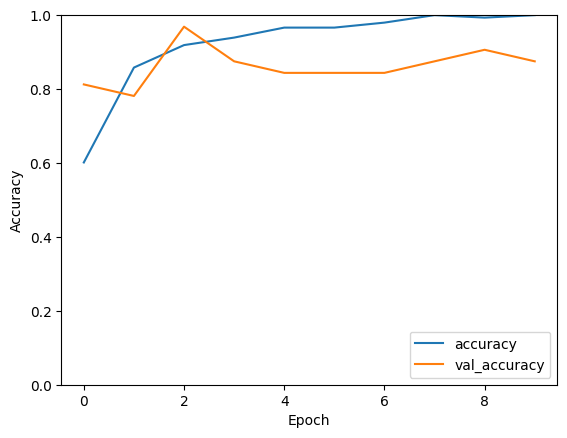

In [22]:
import matplotlib.pyplot as plt
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [23]:
from tensorflow.keras.models import load_model

model = load_model("object_detection_model.h5")



In [24]:
import cv2

cap = cv2.VideoCapture(1)  # 0 indicates the default camera (you can change it based on your camera setup)


In [25]:
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("object_detection_model.h5")

# Load the CSV file
csv_file_path = "check.csv"
check_df = pd.read_csv(csv_file_path)

# Open a camera feed
cap = cv2.VideoCapture(1)

while True:
    ret, frame = cap.read()

    # Preprocess the frame (resize, normalize, etc.)
    input_frame = cv2.resize(frame, (224, 224))
    input_frame = np.expand_dims(input_frame, axis=0) / 255.0  # Normalize to [0, 1]

    # Perform object detection
    predictions = model.predict(input_frame)

    # Get class predictions and bounding box coordinates
    class_idx = np.argmax(predictions)
    confidence = predictions[0, class_idx]

    # Get the label from the model
    label = classes[class_idx]

    # Check if the label is present in the DataFrame
    if label in check_df['name'].values:
        # Get the corresponding category
        category = check_df[check_df['name'] == label]['category'].values[0]

        # Draw a red box if the category is 'no', else draw a green box
        if category.lower() == 'no':
            cv2.rectangle(frame, (0, 0), (frame.shape[1], frame.shape[0]), (0, 0, 255), 2)  # Red box
            cv2.putText(frame, f"{label}: {confidence:.2f} (Category: No)", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        else:
            cv2.rectangle(frame, (0, 0), (frame.shape[1], frame.shape[0]), (0, 255, 0), 2)  # Green box
            cv2.putText(frame, f"{label}: {confidence:.2f} (Category: Yes)", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    else:
        # Draw a red box if the label is not found in the CSV file
        cv2.rectangle(frame, (0, 0), (frame.shape[1], frame.shape[0]), (255, 0, 255), 2)  # Red box
        cv2.putText(frame, f"{label}: {confidence:.2f} (Not in category)", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2)

    # Display the frame
    cv2.imshow("Object Detection", frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print(label)
        break

# Release the camera and close all windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 158ms/step
none


In [2]:
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("object_detection_model.h5")

# Load the CSV file
csv_file_path = "check.csv"
check_df = pd.read_csv(csv_file_path)

# Get the screen resolution
screen_width, screen_height = 1000, 768  # Set your laptop screen resolutionq

# Open a camera feed
cap = cv2.VideoCapture(1)

# Set the window dimensions to cover the whole screen
cv2.namedWindow("Object Detection", cv2.WND_PROP_FULLSCREEN)
cv2.setWindowProperty("Object Detection", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

while True:
    ret, frame = cap.read()

    # Preprocess the frame (resize, normalize, etc.)
    input_frame = cv2.resize(frame, (224, 224))
    input_frame = np.expand_dims(input_frame, axis=0) / 255.0  # Normalize to [0, 1]

    # Perform object detection
    predictions = model.predict(input_frame)

    # Get class predictions and bounding box coordinates
    class_idx = np.argmax(predictions)
    confidence = predictions[0, class_idx]

    # Get the label from the model
    label = classes[class_idx]

    # Check if the label is present in the DataFrame
    if label in check_df['name'].values:
        # Get the corresponding category
        category = check_df[check_df['name'] == label]['category'].values[0]

        # Draw a red box if the category is 'no', else draw a green box
        if category.lower() == 'no':
            cv2.rectangle(frame, (0, 0), (screen_width, screen_height), (0, 0, 255), 2)  # Red box
            cv2.putText(frame, f"{label}: {confidence:.2f} (Category: No)", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        else:
            cv2.rectangle(frame, (0, 0), (screen_width, screen_height), (0, 255, 0), 2)  # Green box
            cv2.putText(frame, f"{label}: {confidence:.2f} (Category: Yes)", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    else:
        # Draw a red box if the label is not found in the CSV file
        cv2.rectangle(frame, (0, 0), (screen_width, screen_height), (255, 0, 255), 2)  # Red box
        cv2.putText(frame, f"{label}: {confidence:.2f} (Not in category)", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2)

    # Display the frame
    cv2.imshow("Object Detection", frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print(label)
        break

# Release the camera and close all windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 129ms/step


1/1 [==============================] - 0s 136ms/step
none
